In [152]:
import torch
import random
import numpy as np  # numpy
import torch.nn as nn  # nn objects
import torch.optim as optim  # nn optimizers
import matplotlib.pyplot as plt
%matplotlib notebook

## custom packages ##
from networkUtils import recurrentNet as rn
from networkUtils import LSTMNet as lstm
from taskUtils import generate as gen
from trainUtils import trainer as tn
from testUtils import test, plot

# Set device to gpu if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [173]:
# Hyperparameters
input_size = 5
num_classes = 2  # the number of units in the output layer
hidden_size = 8  # the number of units in the recurrent layer
batch_size = 1  # batch size = # of samples to average when computing gradient
num_layers = 1  # number of stacked RNN/LSTM layers
eta = 0.005  # learning rate - note that the learning rate had to increase by a factor of 10
epochs = 1000  # epochs = # of full pases through dataset
num_networks = 5 # number of networks to average when calculating loss

In [174]:
# Loss function, optimizer, and schedule (for decaying learning rate)
criterion = nn.CrossEntropyLoss()  # loss function

In [175]:
def get_loss(num_networks, condition, network_type='recurrent', generate_new=True, same_distractions=False, verbose=False):
    seqlen1, seqlen2, seqlen3 = condition[0], condition[1], condition[2]
    losses = []
    mean_loss = np.array([])
    seeds = []
    for i in range(num_networks):
        seed = rn.RecurrentXORNet(input_size, hidden_size, num_layers, num_classes, batch_size, random_h0=True).to(device)
        if network_type == 'lstm':
            seed = lstm.LSTMXORNet(input_size, hidden_size, num_layers, num_classes, batch_size, random_h0=True, random_c0=True).to(device)
        optimizer = optim.Adam(seed.parameters(), eta)  # tells optimizer to adjust all parameter weights with steps based on eta
        sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=False) # lowers lr if the loss global min doesn't decrease for 5 epochs
        dataset, targets, sequence_length = gen.generate_dataset(same_distractions, input_size, seqlen1, seqlen2, seqlen3)
        loss = tn.train_network(seed, dataset, targets, sequence_length, input_size, batch_size, epochs, optimizer, criterion, sheduler, generate_new=generate_new, same_distractions=same_distractions, condition=condition, verbose=verbose)
        if i == 0:
            mean_loss = loss
        else:
            mean_loss = mean_loss + loss
        seeds.append(seed)
        losses.append(loss)
    losses = np.array(losses)
    mean_loss = mean_loss/num_networks
    return mean_loss, losses, seeds

In [176]:
small_middle = [0, 3, 0] # small train in the middle
large_middle = [0, 6, 0] # large train in the middle

In [177]:
mean_loss_small_recurrent,losses_small_recurrent,_ = get_loss(num_networks, small_middle)
mean_loss_large_recurrent,losses_large_recurrent,_ = get_loss(num_networks, large_middle)
mean_loss_small_lstm,losses_small_lstm,_ = get_loss(num_networks, small_middle, network_type='lstm')
mean_loss_large_lstm,losses_large_lstm,_ = get_loss(num_networks, large_middle, network_type='lstm')

Cost at epoch 0 is 0.7515044212341309
Cost at epoch 250 is 0.6778087615966797
Cost at epoch 500 is 0.0454079806804657
Cost at epoch 750 is 0.00943140871822834
Cost at epoch 999 is 0.0037421812303364277
Cost at epoch 0 is 0.7379053235054016
Cost at epoch 250 is 0.7025240659713745
Cost at epoch 500 is 0.6933314800262451
Cost at epoch 750 is 0.7001863718032837
Cost at epoch 999 is 0.7003026604652405
Cost at epoch 0 is 0.7056841850280762
Cost at epoch 250 is 0.01310653518885374
Cost at epoch 500 is 0.17234604060649872
Cost at epoch 750 is 0.0008024749113246799
Cost at epoch 999 is 0.0004833093553315848
Cost at epoch 0 is 0.7180685997009277
Cost at epoch 250 is 0.6944329738616943
Cost at epoch 500 is 0.03017110377550125
Cost at epoch 750 is 0.0038137261290103197
Cost at epoch 999 is 0.0015939926961436868


<IPython.core.display.Javascript object>


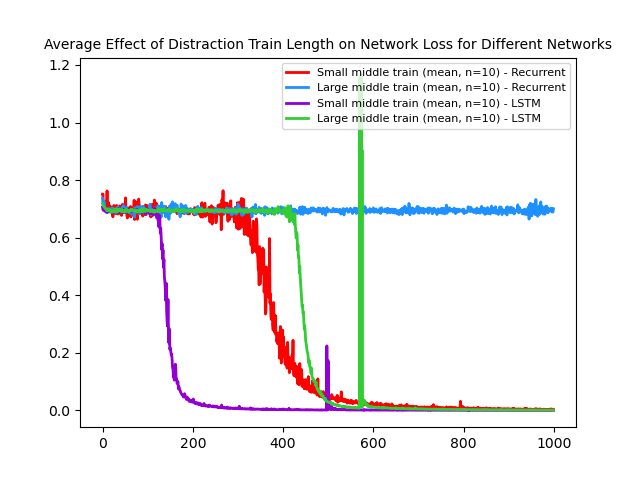

In [178]:
# plot losses
plt.title("Average Effect of Distraction Train Length on Network Loss for Different Networks", fontsize=10)
plot.plot_individual_losses(losses_small_recurrent, color='lightcoral', linewidth=0.7)
plot.plot_individual_losses(losses_large_recurrent, color='lightskyblue', linewidth=0.7)
plot.plot_individual_losses(losses_small_lstm, color='violet', linewidth=0.7)
plot.plot_individual_losses(losses_large_lstm, color='lightgreen', linewidth=0.7)
plt.plot(mean_loss_small_recurrent, color='red', label="Small middle train (mean, n=10) - Recurrent", linewidth=2)
plt.plot(mean_loss_large_recurrent, color='dodgerblue', label="Large middle train (mean, n=10) - Recurrent", linewidth=2)
plt.plot(mean_loss_small_lstm, color='darkviolet', label="Small middle train (mean, n=10) - LSTM", linewidth=2)
plt.plot(mean_loss_large_lstm, color='limegreen', label="Large middle train (mean, n=10) - LSTM", linewidth=2)
plt.legend(fontsize=8) # by default, the legend ignores all elements without a label attribute set.
plt.show()